In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import CubicSpline, lagrange
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial
import random
import os

In [15]:
path_to_dir= "../sem_simulator/data/in"

orig_dir = os.path.join(path_to_dir, 'raw')

bin_dir = os.path.join(path_to_dir, 'bin_masks')
den_dir = os.path.join(path_to_dir, 'denoised')
masks_dir = os.path.join(path_to_dir, 'iter2part12_part13_E200_G73_sem_masks')
# masks_dir = os.path.join(path_to_dir, 'sem_mask')


# other = os.path.join(path_to_dir, 'mask_scunet_correct')
filenames_masks = os.listdir(masks_dir)
# filenames.sort()
print(f'Total: {len(filenames_masks)} files')
# os.makedirs(mask_dir, exist_ok=True)

Total: 51 files


In [16]:
file_name = filenames_masks[0]
file_name[:-4]

'G73_C12_R3___25'

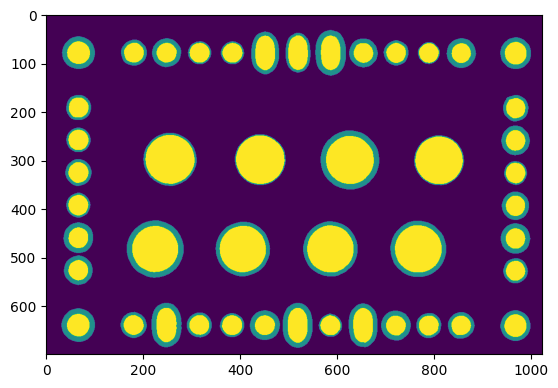

In [17]:
circle2 = cv2.imread(os.path.join(masks_dir, file_name), 0)
circle2 = circle2[20:720, :]
plt.imshow(circle2)

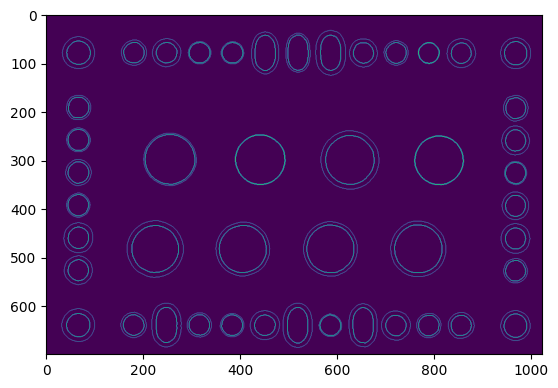

In [18]:
mask_bord = cv2.inRange(circle2, 128,128)
cont_circle2, hier_circle2 = cv2.findContours(mask_bord, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
ext = []
int = []
test = np.zeros_like(circle2)

for i in range(len(cont_circle2)):
    mask_cont = np.zeros_like(circle2)

    if hier_circle2[0][i][3] == -1:
        mask_cont = cv2.drawContours(mask_cont, [cont_circle2[i]], 0, 200, 0)
        cv2.drawContours(test, [cont_circle2[i]], 0, 128, 0)

        plt.imshow(mask_cont)
        nonzero = np.argwhere(mask_cont > 0)
        nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])
        ext.append(nonzero)

    else:
        mask_cont = cv2.drawContours(mask_cont, [cont_circle2[i]], 0, 1, 0)
        cv2.drawContours(test, [cont_circle2[i]], 0, 255, 0)
        plt.imshow(mask_cont)
        nonzero = np.argwhere(mask_cont > 0)
        nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])
        int.append(nonzero)

plt.imshow(test)

In [19]:
def closest_point(point, array):
     diff = array - point
     distance = np.einsum('ij,ij->i', diff, diff)
     return np.argmin(distance), distance

def parabola(x, a, b, c):
    return a*x**2 + b*x + c


def draw_gradient_line(img, start_point, points, colors, thickness=4, flag=None):
    start = start_point
    if flag is None:
        for i in range(1, len(points) - 1):
            # if img[start[1], start[0]] == 0 or img[start[1], start[0]] == 255 or img[start[1], start[0]]==128:
            cv2.line(img, start, points[i+1], colors[i], thickness)
            start = points[i]
    elif flag == 'ext':
        for i in range(1, len(points) - 1):
            if img[start[1], start[0]] == 0 or img[start[1], start[0]] == 255 or img[start[1], start[0]]==128:
                print(start)
                cv2.line(img, start, points[i+1], colors[i], thickness)
                start = points[i]



def compute_previous_pixel(first_pixel, last_pixel, distance=1):
    x1, y1 = first_pixel
    x2, y2 = last_pixel

    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    t = -distance / length
    x_t = np.round((x1 + t * (x2 - x1)), 0).astype(np.int32)
    y_t = np.round((y1 + t * (y2 - y1)), 0).astype(np.int32)

    return (x_t, y_t)

def compute_next_pixel(first_point, last_point, distance=1):
    x1, y1 = first_point
    x2, y2 = last_point

    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    t = 1 + distance / length
    x_t = np.round((x1 + t * (x2 - x1)), 0).astype(np.int32)
    y_t = np.round((y1 + t * (y2 - y1)), 0).astype(np.int32)

    return (x_t, y_t)

In [20]:
from skimage.draw import line


# fig, ax = plt.subplots(1,1,figsize=(10, 10))
# cp = np.zeros_like(circle2)
# ax.imshow(cp)
# modes = []
color_back = 110
color_hole = 85

width_img = np.zeros_like(circle2, dtype=np.float32)
angles_img = np.zeros_like(circle2, dtype=np.float32)
# new_angles = circle2.copy()
new_angles = np.zeros_like(circle2, dtype=np.float32)
color_map = np.zeros_like(circle2, dtype=np.float32)
color_map[circle2 == 0] = color_back
color_map[circle2 == 255] = color_hole
  

for cont_ext, cont_int in zip(ext, int):
    for point in cont_ext:
            min_dist = float('inf')
            index, dist = closest_point(point, cont_int)
            if dist[index] < min_dist :
                min_dist = dist[index].item()
                nearest_point = cont_int[index]
                # chosen_point_c1 = t  
                dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                dist_ = dist_.item()
                # print(type(dist_))
            # print(min_dist, dist_)
            if dist_ == 0:
                dist_ = 1
            discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
            # discrete_line_x = np.array(list(zip(*discrete_line))[0])
            
            mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
            prev = [compute_previous_pixel(point, nearest_point)]
            next = [compute_next_pixel(point, nearest_point)]
            # print(next)

            angle = np.arctan(700 / (dist_ * 12))
            cv2.line(width_img, point, nearest_point, dist_, 2)
            cv2.line(angles_img, point, nearest_point, angle, 3)

            height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(0, dist_+2)]
            discrete_line_ = discrete_line + next

            draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)

            if dist_ >= 3:
                k = dist_/10
                if k < 1:
                    val = angle*k
                else:
                    val = angle/k
                y_mean = val
                y_0 = val/2
                y_n = val/2
                x_plot = np.arange(0, len(discrete_line)+2)
                coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                a,b,c = coefs[0]
                y_parabola = parabola(x_plot, a, b, c)
                heights = y_parabola
                if dist_ > 10:
                    thickness = 5
                else:
                    thickness = 3
                discrete_line_ = prev + discrete_line + next
                # print(discrete_line, discrete_line_)
                draw_gradient_line(new_angles, point, discrete_line_, y_parabola, thickness=thickness)
            else:
                val = angle
                cv2.line(new_angles, point, nearest_point, val, 3)


for cont_ext, cont_int in zip(ext, int):
    for point in cont_int:
            min_dist = float('inf')
            index, dist = closest_point(point, cont_ext)
            if dist[index] < min_dist :
                min_dist = dist[index].item()
                nearest_point = cont_ext[index]
                # chosen_point_c1 = t  
                dist_ = np.sqrt((point[0] - nearest_point[0])**2 + (point[1] - nearest_point[1])**2).astype(np.int32)
                dist_ = dist_.item()
                # print(type(dist_))
            if dist_ == 0:
                dist_ = 1
            discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
            # discrete_line_x = np.array(list(zip(*discrete_line))[0])
            
            mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
            prev = [compute_previous_pixel(point, nearest_point)]
            next = [compute_next_pixel(point, nearest_point)]
            # print(next)

            angle = np.arctan(700 / (dist_ * 12))
            cv2.line(width_img, point, nearest_point, dist_, 2)
            cv2.line(angles_img, point, nearest_point, angle, 3)

            height_vals = [((k_ * ((color_back - color_hole) / dist_)) + color_hole) for k_ in range(1, dist_+2)]
            # height_vals = [(color_back - (k_ * ((color_back - color_hole) / dist_))) for k_ in range(1, dist_+2)]


            discrete_line_ =discrete_line + next
            draw_gradient_line(color_map, point, discrete_line_, height_vals, thickness=3)
            if dist_ >= 3:
                k = dist_/10

                if k < 1:
                    val = angle*k
                else:
                    val = angle/k
                y_mean = val
                y_0 = val/2
                y_n = val/2
                x_plot = np.arange(0, len(discrete_line)+2)
                coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                a,b,c = coefs[0]
                y_parabola = parabola(x_plot, a, b, c)
                if dist_ > 10:
                    thickness = 5
                else:
                    thickness = 3
                
                discrete_line_ = prev + discrete_line + next
                # print(discrete_line, discrete_line_)
                draw_gradient_line(new_angles, point, discrete_line_, y_parabola, thickness=thickness)
            else:
                val = angle
                cv2.line(new_angles, point, nearest_point, val, 3)


mask = circle2 != 128 

width_img[mask] = 0
angles_img[mask] = 0

color_map[circle2 == 0] = color_back
color_map[circle2 == 255] = color_hole


# angles_img = cv2.GaussianBlur(angles_img, (7, 7), 0)
# color_map = cv2.GaussianBlur(color_map, (7, 7), 0)

new_angles[new_angles == 0] = np.nan
new_angles[mask] = 0
mask1 = np.isnan(new_angles)

# color_map[color_map] = 0
color_map[color_map == 0] = np.nan
color_map[circle2 == 0] = color_back
color_map[circle2 == 255] = color_hole
mask2 = np.isnan(color_map)

new_angles = cv2.inpaint(new_angles, mask1.astype(np.uint8), inpaintRadius=3, flags=cv2.INPAINT_NS)
new_angles = cv2.GaussianBlur(new_angles, (7, 7), 0)

color_map = cv2.inpaint(color_map, mask2.astype(np.uint8), inpaintRadius=3, flags=cv2.INPAINT_NS)
color_map = cv2.GaussianBlur(color_map, (7, 7), 0)


new_angles = cv2.GaussianBlur(new_angles, (7, 7), 0)



Text(0.5, 1.0, 'color_map')

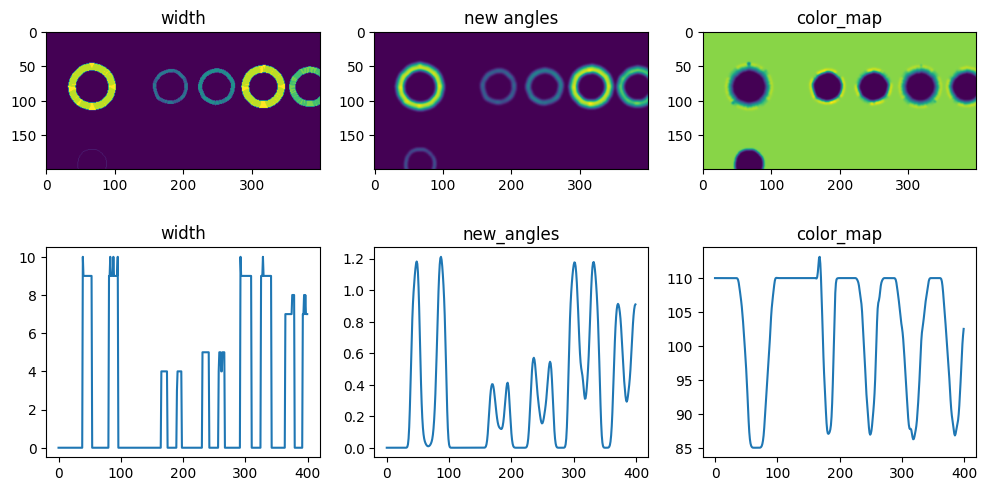

In [10]:
y = 50

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0,0].imshow(width_img[:200, :400])
# ax[0,0].scatter(mid_point[0], mid_point[1])
ax[0,0].set_title(f'width')


ax[0,1].imshow(new_angles[:200, :400])
ax[0,1].set_title(f'new angles')

ax[0,2].imshow(color_map[:200, :400])
ax[0,2].set_title(f'color_map')

# print(angles_img[mid_point[1], mid_point[0]])
ax[1,0].plot(width_img[:200, :400][60, :])
# ax[1,0].scatter(mid_point[0], angles_img[mid_point[1], mid_point[0]])
ax[1,0].set_title(f'width')


ax[1,1].plot(new_angles[:200, :400][60, :])
ax[1,1].set_title(f'new_angles')

ax[1,2].plot(color_map[:200, :400][60, :])
ax[1,2].set_title(f'color_map')

MAX value:  1.2948782
MIN value:  0.0


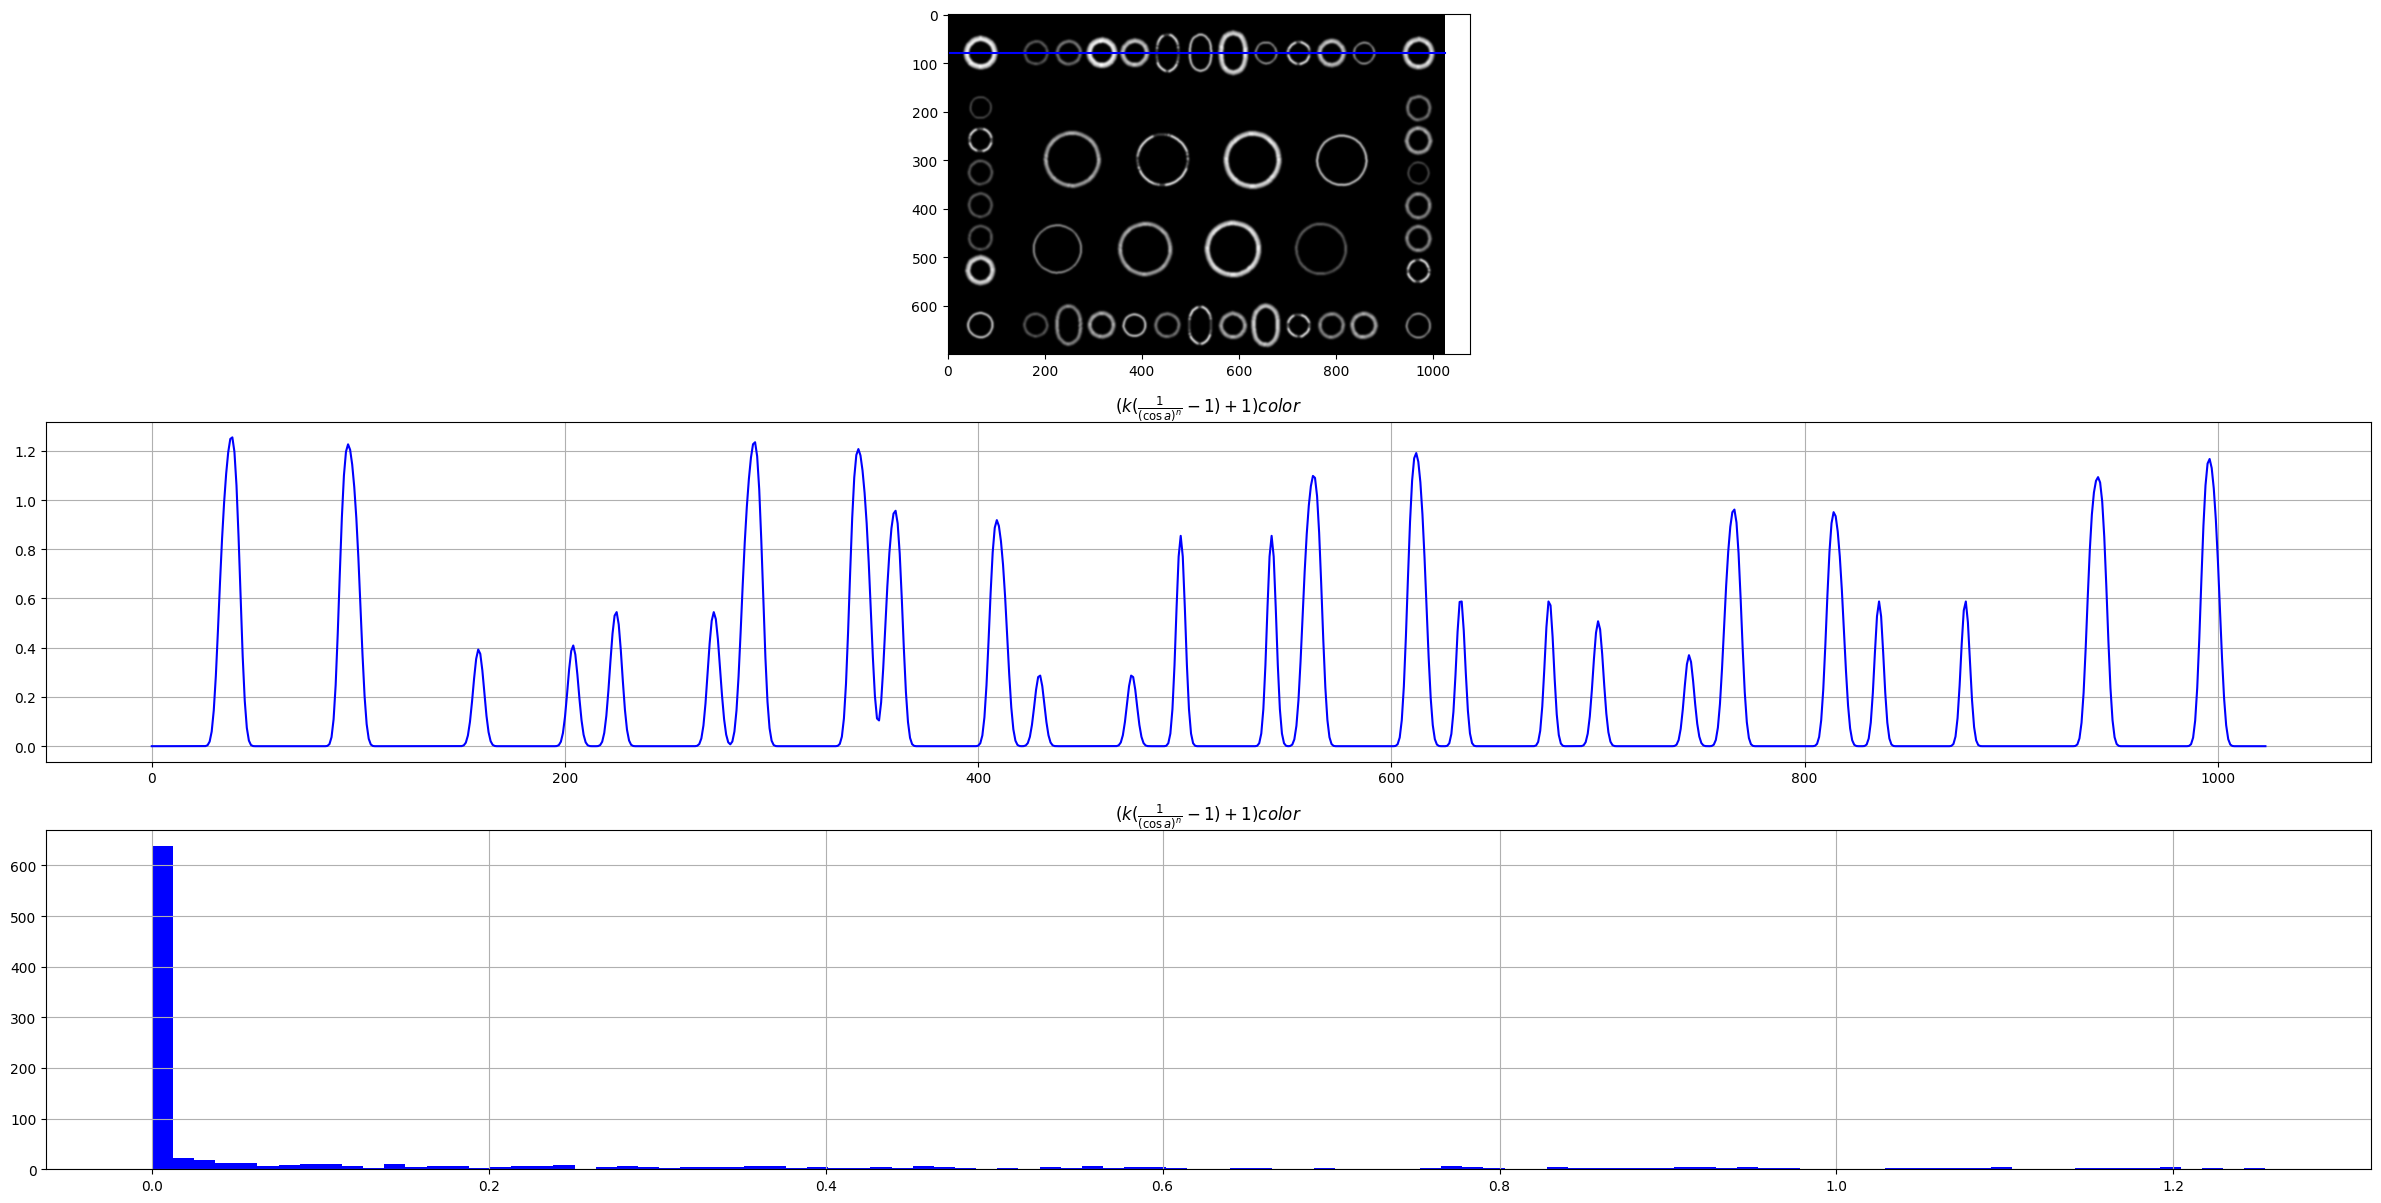

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(30, 15))
ax[0].imshow(new_angles, cmap='gray')
ax[0].plot([0,new_angles.shape[1]], [80, 80], color='blue')

ax[1].plot(new_angles[80, :], color='blue')
ax[1].grid()
ax[1].set_title(r'$(k(\frac{1}{(\cos a)^n} - 1) + 1)color$')

ax[2].hist(new_angles[80, :], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$(k(\frac{1}{(\cos a)^n} - 1) + 1)color$')

print('MAX value: ', new_angles.ravel().max())
print('MIN value: ', new_angles.ravel().min())

### Разные формулы сигнала

#### Формула №1

mean back 62.439938
mean hole 200.68486
mean bord 29.793074
MIN bord 27.003578
mean color bord:  104.38746
MAX value:  255.0
MIN value:  112.004524


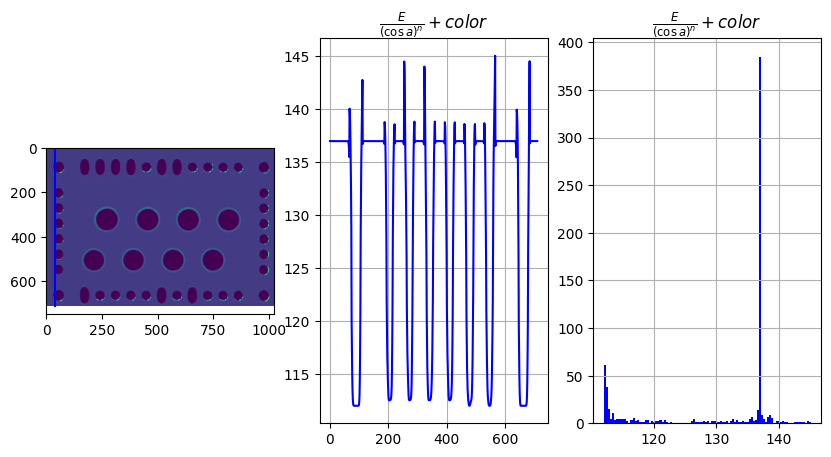

In [127]:
def formula_first(img, angles, color_map, E):
    signal = np.zeros_like(img, dtype=np.float32)

    alpha_bord = angles[img == 128]
    alpha_bord[alpha_bord==alpha_bord.min()] = np.radians(1)

    alpha_back = angles[img == 0]
    alpha_hole = angles[img == 255]

    print('mean back', np.mean(E / np.abs(np.cos(alpha_back + 1))**(0.87)))
    print('mean hole', np.mean(E / np.abs(np.cos(alpha_hole + 1))**(1.1)))
    print('mean bord', np.mean((E / np.abs(np.cos(alpha_bord)))**(0.87)))
    print('MIN bord', (E / np.abs(np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord)))**(0.87)).min())
    print('mean color bord: ', np.mean(color_map[img==128]))

    # signal[crop == 0] =  E / np.cos(alpha_back + 1)**(0.87) + 100
    signal[img == 0] =  (E / (np.abs(np.cos(np.radians(alpha_back + 1)))**(0.87))) + color_map[img==0]

    # signal[crop == 128] = E / np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord))**(0.87) + 120
    # signal[crop == 128] = E / np.abs(np.cos(np.radians(90) - alpha_bord))**(0.87) + color_map[crop==128]
    signal[img == 128] = (E / (np.abs(np.cos(np.radians(90) - (np.radians(180 - 90) - alpha_bord)))**(0.87))) + color_map[img==128]


    # signal[crop == 255] = E / np.cos(alpha_hole + 1)**(1.1) + 60
    signal[img == 255] = (E / (np.abs(np.cos(np.radians(alpha_hole + 1)))**(1.1))) + color_map[img==255]

    signal = np.clip(signal, 0, 255)
    signal_first = cv2.GaussianBlur(signal, (3, 3), 0)

    cv2.imwrite(f'./data/out/new_raw/{file_name[:-4]}_signal_E{E}_13.png', signal.astype(np.uint8))


    return signal

signal_first = formula_first(circle2, new_angles, color_map, E=27)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(signal_first)
ax[0].plot([38, 38], [0, signal_first.shape[0]], color='blue')

ax[1].plot(signal_first[:, 38], color='blue')
ax[1].grid()
ax[1].set_title(r'$\frac{E}{(\cos a)^n} + color$')


ax[2].hist(signal_first[:, 38], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$\frac{E}{(\cos a)^n} + color$')


print('MAX value: ', signal_first.ravel().max())
print('MIN value: ', signal_first.ravel().min())


#### Формула №2

MAX value:  255.0
MIN value:  85.00427


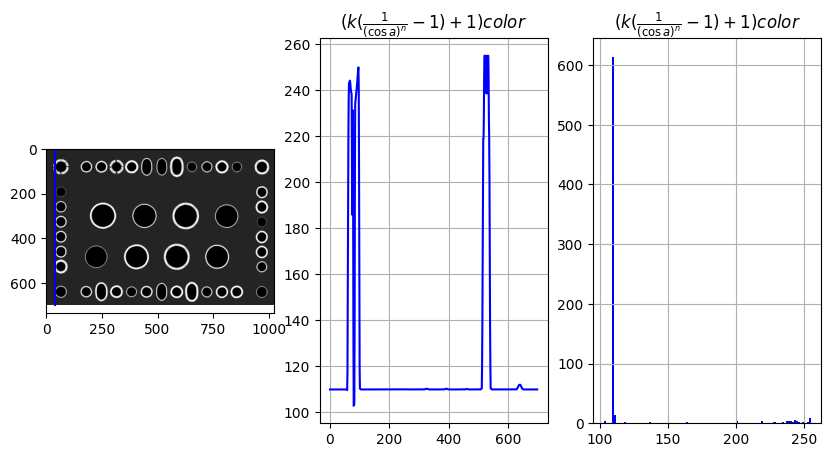

In [14]:
def formula_second(img, angles, color_map, k):
    signal = np.zeros_like(img, dtype=np.float32)


    alpha_bord = angles[img == 128]

    alpha_bord[alpha_bord==alpha_bord.min()] = np.radians(1)

    alpha_back = angles[img == 0]
    alpha_hole = angles[img == 255]

    # k = k
    signal[img == 0] = (k*(1/(np.abs(np.cos(np.radians(alpha_back + 1)))**(0.87)) - 1) + 1) * color_map[img==0]

    signal[img == 128] = (k * (1/(np.abs(np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord)))**(0.87)) - 1) + 1) *color_map[img==128]


    signal[img == 255] = (k * (1 / (np.abs(np.cos(np.radians(alpha_hole + 1)))**(1.1)) - 1) + 1) * color_map[img==255]

    signal = np.clip(signal, 0, 255)
    signal = cv2.GaussianBlur(signal, (3, 3), 0)

    cv2.imwrite(f'./data/out/simulated_raw/{file_name[:-4]}_signal_k{k}_19.png', signal.astype(np.uint8))

    return signal

signal_second = formula_second(circle2, angles_img, color_map, 0.3)
  

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(signal_second, cmap='gray')
ax[0].plot([38, 38], [0,signal_second.shape[0]], color='blue')

ax[1].plot(signal_second[:, 38], color='blue')
ax[1].grid()
ax[1].set_title(r'$(k(\frac{1}{(\cos a)^n} - 1) + 1)color$')

ax[2].hist(signal_second[:, 38], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$(k(\frac{1}{(\cos a)^n} - 1) + 1)color$')

print('MAX value: ', signal_second.ravel().max())
print('MIN value: ', signal_second.ravel().min())



MAX value:  255.0
MIN value:  85.00427


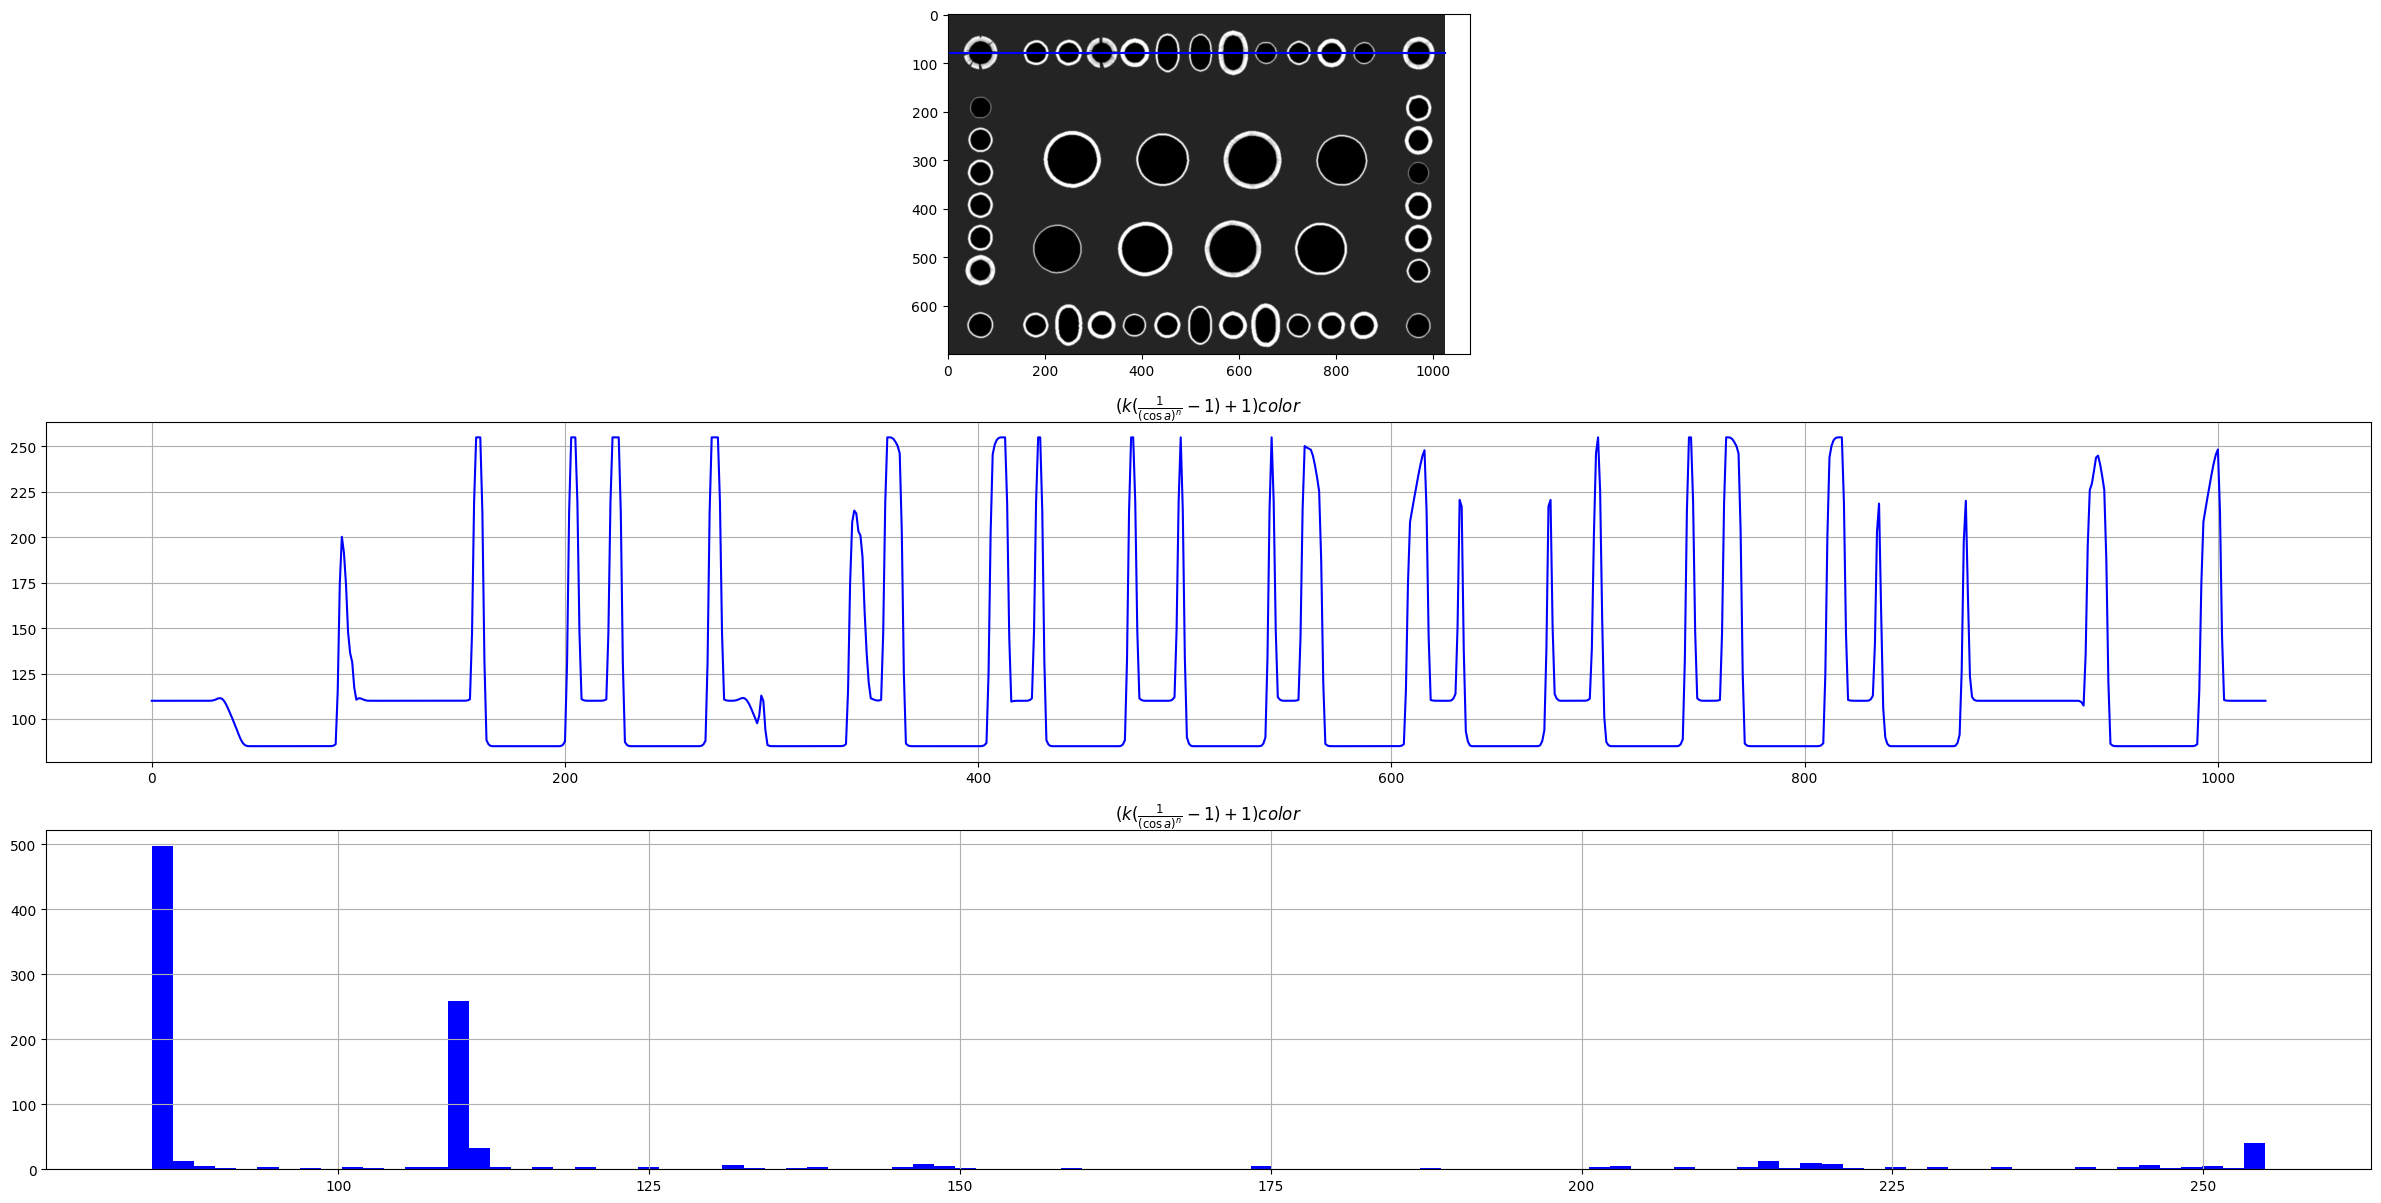

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(30, 15))
ax[0].imshow(signal_second, cmap='gray')
ax[0].plot([0,signal_second.shape[1]], [80, 80], color='blue')

ax[1].plot(signal_second[80, :], color='blue')
ax[1].grid()
ax[1].set_title(r'$(k(\frac{1}{(\cos a)^n} - 1) + 1)color$')

ax[2].hist(signal_second[80, :], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$(k(\frac{1}{(\cos a)^n} - 1) + 1)color$')

print('MAX value: ', signal_second.ravel().max())
print('MIN value: ', signal_second.ravel().min())